In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
import datetime
import matplotlib
from matplotlib import pyplot


prediction_trend_data = [] 
input_numeric_columns = []
input_categorical_columns = []
output_columns = []

normalize = False
dfOriginal = pd.read_csv('../Data/finalSeriesForTrainingWithLatLon.csv', parse_dates=['Date'])
df = dfOriginal
all_columns = list(df)
numeric_regex = re.compile("n_*")
input_numeric_columns = list(filter(numeric_regex.match, all_columns))
categorical_regex = re.compile("c_*")                               
input_categorical_columns = list(filter(categorical_regex.match, all_columns))
output_regex = re.compile("o_*")                               
output_columns = list(filter(output_regex.match, all_columns))
metadata_columns = ["Lat", "Lon", "regionToJoin", "Date"]
df = df[input_numeric_columns+input_categorical_columns+output_columns+prediction_trend_data+metadata_columns]
    
if(normalize):
    #normalize data; not necessary for xgboost
    scaler = Normalizer()
    dontNormalize = input_categorical_columns + output_columns + prediction_trend_data + metadata_columns
    df.loc[:, ~df.columns.isin(dontNormalize)] = scaler.fit_transform(df.loc[:, ~df.columns.isin(dontNormalize)])

C:\Users\scott\Anaconda3\envs\python35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X = df[input_numeric_columns+input_categorical_columns]
yColumns = ['o_day1DangerAboveTreeline']
yAbove=df[yColumns + metadata_columns]
X_Above_train, X_Above_test, y_Above_train, y_Above_test = train_test_split(X, yAbove, stratify=yAbove["o_day1DangerAboveTreeline"], test_size=0.20, random_state=1)
yNearColumn = ['o_day1DangerNearTreeline'];
yNear=df[yNearColumn+metadata_columns]
X_Near_train, X_Near_test, y_Near_train, y_Near_test = train_test_split(X, yNear, stratify=yNear['o_day1DangerNearTreeline'], test_size=0.20, random_state=1)
yBelowColumn = ['o_day1DangerBelowTreeline']
yBelow=df[yBelowColumn+metadata_columns]
X_Below_train, X_Below_test, y_Below_train, y_Below_test = train_test_split(X, yBelow, stratify=yBelow['o_day1DangerBelowTreeline'], test_size=0.20, random_state=1)

In [3]:
X_Below_train.head()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,c_r_Prev3DayWindSlabLikeliness8InPast,c_r_Prev7DayWindSlabLikeliness8InPast,c_r_Prev3DayFreezeThawLikeliness9InPast,c_r_Prev7DayFreezeThawLikeliness9InPast,c_r_Prev3DayWindSlabLikeliness9InPast,c_r_Prev7DayWindSlabLikeliness9InPast,c_r_Prev3DayFreezeThawLikeliness10InPast,c_r_Prev7DayFreezeThawLikeliness10InPast,c_r_Prev3DayWindSlabLikeliness10InPast,c_r_Prev7DayWindSlabLikeliness10InPast
33464,0.000,1.668579,0.000,1.474448,0.000,0.971417,0.000,0.919629,0.125,0.859770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54341,12.125,3.742117,13.375,3.358029,14.625,3.127075,15.875,3.416421,16.625,3.241543,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
35779,6.875,2.924495,6.875,2.705076,6.875,2.116717,7.000,1.734731,7.000,1.106689,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
12826,1.625,6.239301,1.875,6.704172,1.875,6.704172,2.000,6.801766,2.000,6.801766,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
8530,0.000,2.620770,0.000,2.696139,0.000,2.696139,0.000,2.583893,0.000,2.583893,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [4]:
y_Below_test['o_day1DangerBelowTreeline'].value_counts()

Low             7115
Moderate        5843
Considerable    1839
High             157
Name: o_day1DangerBelowTreeline, dtype: int64

In [5]:
#parameters derived from a several step parameter search
grid = {'min_child_weight': 5, 'n_estimators': 250, 'colsample_bytree': 0.9, 'reg_alpha': 1, 'gamma': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'objective': 'multi:softmax', 'max_depth': 7}

modelAbove = XGBClassifier()
modelAbove.set_params(**grid)

modelNear = XGBClassifier()
modelNear.set_params(**grid)

modelBelow = XGBClassifier()
modelBelow.set_params(**grid)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=1, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=250, nthread=-1,
       objective='multi:softmax', reg_alpha=1, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

In [6]:
val = modelAbove.fit(X_Above_train, y_Above_train[yColumns].values.ravel())
valnear = modelNear.fit(X_Near_train, y_Near_train[yNearColumn].values.ravel())
valbelow = modelBelow.fit(X_Below_train, y_Below_train[yBelowColumn].values.ravel())

In [7]:
resultAbove = modelAbove.predict(X_Above_test)
resultNear = modelNear.predict(X_Near_test)
resultBelow = modelBelow.predict(X_Below_test)

C:\Users\scott\Anaconda3\envs\python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\scott\Anaconda3\envs\python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\scott\Anaconda3\envs\python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [8]:
def evaluateSingleClass(y_test, result):
    cm = confusion_matrix(y_test, result)
    print(cm)
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

def evaluateSingleClassShort(y_test, result):
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

#nice confustion matrix plot taken from scikit-learn docs
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 0.9667647452186706
Classification Report
              precision    recall  f1-score   support

Considerable       0.95      0.96      0.95      4450
        High       0.94      0.92      0.93      1077
         Low       0.98      0.99      0.99      3849
    Moderate       0.98      0.96      0.97      5578

 avg / total       0.97      0.97      0.97     14954

Normalized confusion matrix
Confusion matrix, without normalization


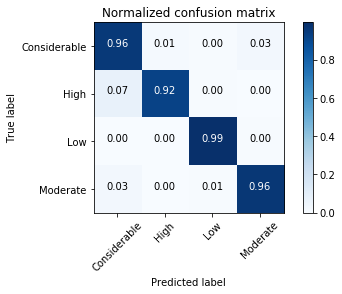

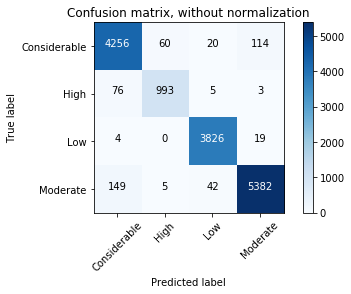

In [15]:
evaluateSingleClassShort(y_Above_test['o_day1DangerAboveTreeline'], resultAbove)
cnf_matrix = confusion_matrix(y_Above_test['o_day1DangerAboveTreeline'], resultAbove)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

Accuracy: 0.9575364450983015
Classification Report
              precision    recall  f1-score   support

Considerable       0.94      0.94      0.94      3515
        High       0.96      0.91      0.94       779
         Low       0.98      0.98      0.98      4688
    Moderate       0.96      0.96      0.96      5972

 avg / total       0.96      0.96      0.96     14954

Normalized confusion matrix
Confusion matrix, without normalization


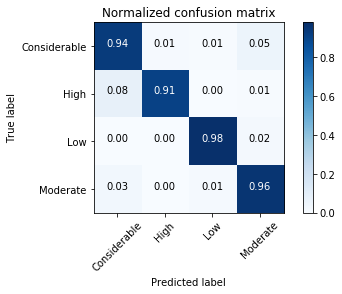

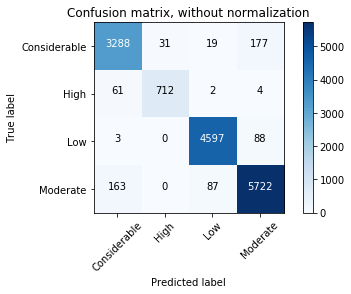

In [16]:
evaluateSingleClassShort(y_Near_test['o_day1DangerNearTreeline'], resultNear)

cnf_matrix = confusion_matrix(y_Near_test['o_day1DangerNearTreeline'], resultNear)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

Accuracy: 0.9614818777584593
Classification Report
              precision    recall  f1-score   support

Considerable       0.93      0.93      0.93      1839
        High       0.96      0.92      0.94       157
         Low       0.98      0.98      0.98      7115
    Moderate       0.95      0.95      0.95      5843

 avg / total       0.96      0.96      0.96     14954

Normalized confusion matrix
Confusion matrix, without normalization


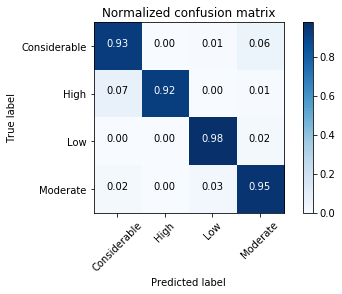

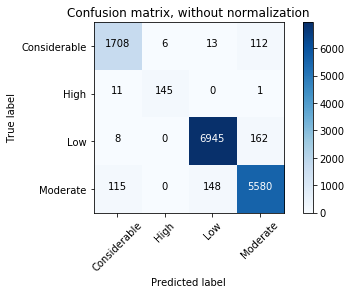

In [17]:
evaluateSingleClassShort(y_Below_test['o_day1DangerBelowTreeline'], resultBelow)
cnf_matrix = confusion_matrix(y_Below_test['o_day1DangerBelowTreeline'], resultBelow)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [18]:
#check out the feature importances
featureImportance = dict(zip(X_Above_train.columns, modelAbove.feature_importances_))
sortedFeatureImportance = sorted(featureImportance, key=featureImportance.get, reverse=True)

In [ ]:
#save the models
modelAbove._Booster.save_model("ModelAboveV1.bin")
modelNear._Booster.save_model("ModelNearV1.bin")
modelBelow._Booster.save_model("ModelBelowV1.bin")